In [ ]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
import pandas as pd

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 522 (delta 83), reused 145 (delta 70), pack-reused 351
Receiving objects: 100% (522/522), 256.07 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (250/250), done.
Updating files: 100% (104/104), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
marker = np.load("drive/MyDrive/MIT687/16S_Kmers/marker_gene.npy")
bacteria = np.load("drive/MyDrive/MIT687/16S_Kmers/target_species.npy")
bacteria = tf.one_hot(bacteria.flatten(), depth=326)

In [ ]:
def create_generator():
    ribo_classifier = tf.keras.models.load_model('drive/MyDrive/MIT687/ribo_classifier.keras')
    ribo_classifier._name = "RiboClassifier"
    origin_generator = tf.keras.models.load_model('AMPLify-Feedback/model_weights/PeptideGenerator_new.keras')
    inputs = tf.keras.layers.Input(shape=(4096),name="SeqInput")
    x = ribo_classifier(inputs)
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(2, activation="tanh")(x)
    x = origin_generator(x)
    new_generator = tf.keras.models.Model(inputs, x, name="PeptideGenerator")
    return new_generator

In [ ]:
def create_oracle():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    return model

In [ ]:
oracle = create_oracle()
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(oracle.layers):
    weights = np.load(f"{path}/layer_{i}_weights.npy", allow_pickle=True)
    layer.set_weights(weights)

In [ ]:
aa_vocal = np.load("AMPLify-Feedback/model_weights/SeqTV_vocal.npy")
pep_decoder = tf.keras.layers.StringLookup(vocabulary=aa_vocal[1:], invert=True, oov_token='')
species_vocal = np.load("AMPLify-Feedback/model_weights/SpeciesTV_vocal.npy")
species_decoder = tf.keras.layers.StringLookup(vocabulary=species_vocal[1:], invert=True, oov_token='')

In [ ]:
def onehot2seq(onehot):
  decoded_sequences = []
  chars_array = pep_decoder(tf.math.argmax(onehot, axis=2)).numpy().astype('str')
  decoded_sequences += ["".join(chars) for chars in chars_array]
  return decoded_sequences

In [ ]:
@tf.function
def compute_gradient(oracle, marker, bacteria, generator_optimizer):
    marker = tf.convert_to_tensor(marker, np.int64)
    # bacteria = tf.convert_to_tensor(bacteria, np.float64)
    with tf.GradientTape() as gen_tape:
        gen_tape.watch(marker)
        generated_onehot = generator(marker, training=True)
        generator_loss = tf.reduce_mean(oracle([generated_onehot, bacteria]))
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return generated_onehot

In [ ]:
def RL_loop(generator, oracle, marker, bacteria, n_iter_max):
  average_mic_train, min_mic_train, max_mic_train, median_mic_train, levenstein  = [], [], [], [], []
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for i in range (n_iter_max) :
    #Sequences prediction and gradient computation
    generated_onehot = compute_gradient(oracle, marker, bacteria, generator_optimizer)
    generated_sequences = onehot2seq(generated_onehot)

    #Oracle results and statistics
    MIC = oracle([generated_onehot, bacteria])
    average_mic_train += [np.mean(MIC)]
    min_mic_train += [np.min(MIC)]
    max_mic_train += [np.max(MIC)]
    median_mic_train += [np.median(MIC)]

    print(f"Iter {i+1}/{n_iter_max}; Average MIC {np.mean(MIC):.4f}")

  return generator, average_mic_train, min_mic_train, max_mic_train, median_mic_train

In [ ]:
n_iter_max = 5
generator = create_generator()
generator, average_mic_train, min_mic_train, max_mic_train, median_mic_train = RL_loop(generator, oracle, marker, bacteria, n_iter_max)

Iter 1/5; Average MIC 4.7560
Iter 2/5; Average MIC 4.3673
Iter 3/5; Average MIC 4.1461
Iter 4/5; Average MIC 4.0494
Iter 5/5; Average MIC 3.8327


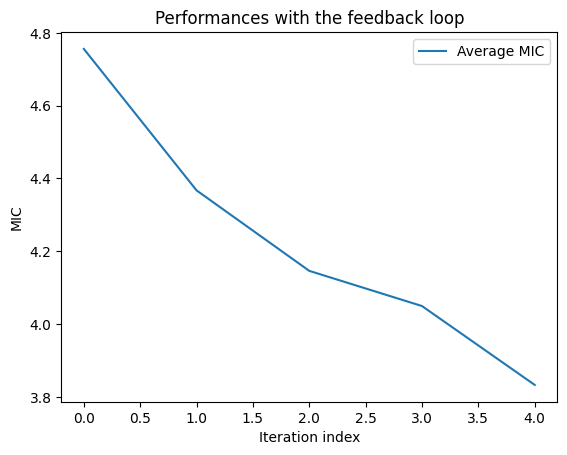

In [ ]:
parameters = {"Average MIC" : average_mic_train,
              # "Minimum MIC" : min_mic_train,
              # "Maximum MIC" : max_mic_train,
              # "Median MIC" : median_mic_train
              }
for p in list(parameters.keys()):
    plt.plot(range(len(parameters[p])), parameters[p], linestyle='-', label = p)
plt.legend(loc = "upper right")
plt.ylabel("MIC")
plt.xlabel("Iteration index")
plt.title("Performances with the feedback loop")
plt.savefig("Average_MIC.png")

In [ ]:
targets = marker[0:300]
idx = tf.argmax(bacteria[0:300], axis=1).numpy()
generated_sequences = generator.predict(targets, verbose=0)
MIC = oracle.predict([generated_sequences, bacteria[0:300]], verbose=0).flatten()
Seq = onehot2seq(generated_sequences)
display_table = pd.DataFrame([species_vocal[idx], Seq, MIC]).transpose()
print(display_table.to_string())

                                      0          1         2
0              Burkholderia_cenocepacia   DVKKLFKF  8.578871
1                  Campylobacter_jejuni  DVKKLFKFH  2.651843
2            Corynebacterium_glutamicum   DVKKLFKF  2.053096
3                     Listeria_ivanovii  DVKKLFKFH  3.927064
4                 Klebsiella_pneumoniae  DVKKLDKFH  3.763291
5                   Salmonella_enterica   DVKKLFKF   3.96329
6               Acinetobacter_baumannii   DVKKLFKF  4.976504
7               Corynebacterium_xerosis   DVKKLFKF  1.032607
8                  Lactobacillus_brevis   DVKKLFKF  3.005815
9                 Klebsiella_pneumoniae  DVKKLDKFH  3.763931
10                    Histophilus_somni   DVKKLFKF  3.129093
11                         Bacillus_sp.   DVKKLFKF  4.869762
12                    Histophilus_somni   DVKKLFKF  3.130042
13                     Escherichia_coli   DVKKLFKF  3.371224
14                  Mycoplasma_mycoides   DVKKLFKF  4.701034
15                     E

In [ ]:
generator.save("drive/MyDrive/MIT687/marker2pep_generator.keras")